In [1]:
%matplotlib inline
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
# reading data
data = pd.read_csv('../vdjdb-dump/vdjdb_a02_4epi_trab_200.txt', sep='\t')

In [3]:
data.head()

,gene,cdr3,v.segm,j.segm,antigen.epitope
0,TRA,CAGAGRGNRDDKIIF,TRAV27*01,TRAJ30*01,GILGFVFTL
1,TRA,CAASALRGMDSNYQLIW,TRAV29/DV5*01,TRAJ33*01,GILGFVFTL
2,TRA,CAARGNYGQNFVF,TRAV29/DV5*01,TRAJ26*01,GILGFVFTL
3,TRA,CAVKNNNDMRF,TRAV12-2*01,TRAJ43*01,GILGFVFTL
4,TRA,CAMSDGGGSNYKLTF,TRAV12-3*01,TRAJ53*01,GILGFVFTL


In [4]:
# renaming columns
data.columns = ['gene', 'CDR3b', 'TRBV', 'TRBJ', 'epitope']

In [5]:
# saving separate files for each chain
for gene in ['TRA', 'TRB']:
    data.loc[data.gene == gene][['CDR3b', 'TRBV', 'TRBJ', ]].to_csv(f'{gene}_gene.txt', sep='\t', index=False)

In [6]:
# running a script
!~/PycharmProjects/vdjdb-classifier-benchmark/gliph/gliph_0517/bin/gliph-group-discovery.pl --tcr 'TRA_gene.txt'; ~/PycharmProjects/vdjdb-classifier-benchmark/gliph/gliph_0517/bin/gliph-group-discovery.pl --tcr 'TRB_gene.txt'


GLIPH - Grouping Lymphocyte Interfaces by Paratope Hotspots
GLIPH-1.0rc

An algorithm for statistical clustering of adaptive repertoire convergence
Contact: Jacob Glanville (jakeg@stanford.edu)

  loading reference db        /home/alex/PycharmProjects/vdjdb-classifier-benchmark/gliph/gliph_0517/db/tcrab-naive-refdb-pseudovdjfasta.fa
Establishing global convergence significance cutoff
Evaluating depth of input sample in determining distance cutoff

Preparing local convergence motifs (3mers,4mers,xx.x,x.xx)
Received local convergence motifs file
  TRA_gene-kmer_resample_1000_minp0.001_ove10.txt as input
Motif	Counts	avgRef	topRef	OvE	p-value
IKA	4	0.11	2	34.188	0.001
GSSN	5	0.37	3	13.297	0.001
NM	17	0.58	4	29.31	0.001
YI	11	0.75	5	14.588	0.001
SGSA	7	0.46	3	15.217	0.001
YNTD	3	0.01	1	249.999	0.001
NF	28	0.85	5	32.71	0.001
SQGN	41	0.3	3	132.686	0.001
YDK	4	0.03	2	129.032	0.001
NAGN	12	0.01	1	1090.909	0.001
GYA	7	0.22	3	31.249	0.001
STDK	3	0.02	1	124.999	0.001
SYDK	4	0.01	1	285.714	0.001



GLIPH - Grouping Lymphocyte Interfaces by Paratope Hotspots
GLIPH-1.0rc

An algorithm for statistical clustering of adaptive repertoire convergence
Contact: Jacob Glanville (jakeg@stanford.edu)

  loading reference db        /home/alex/PycharmProjects/vdjdb-classifier-benchmark/gliph/gliph_0517/db/tcrab-naive-refdb-pseudovdjfasta.fa
Establishing global convergence significance cutoff
Evaluating depth of input sample in determining distance cutoff

Preparing local convergence motifs (3mers,4mers,xx.x,x.xx)
Received local convergence motifs file
  TRB_gene-kmer_resample_1000_minp0.001_ove10.txt as input
Motif	Counts	avgRef	topRef	OvE	p-value
LGQP	11	0.49	4	22.312	0.001
RSA	8	0.79	4	10.025	0.001
QAYE	4	0.37	3	10.723	0.001
RGAD	6	0.47	3	12.578	0.001
SIF	5	0.28	4	17.301	0.001
GMGQ	5	0.14	2	33.557	0.001
GGFS	4	0.22	3	17.937	0.001
SRSG	7	0.68	4	10.189	0.001
MGQP	5	0.11	2	43.103	0.001
IRS	10	0.35	3	28.571	0.001
SIR	17	1.66	7	10.191	0.001
GLGQ	8	0.57	4	14.035	0.001
SIRS	10	0.05	2	185.185	0.001

In [7]:
# adding clusters to data
clusters = []
data['cluster'] = None

# for each chain
for gene in ['TRA', 'TRB']:
    num_clusters = 0
    with open(f'{gene}_gene-convergence-groups.txt') as f:
        for line in f.readlines():
            cluster = line.strip().split('\t')[-1].split(' ')
            
            # if a cluster has < 10 members than pass
            if len(cluster) > 9:
                for cdr in cluster:
                    
                    # assigning a cluster
                    data.loc[(data.CDR3b == cdr) & (data.gene == gene), 'cluster'] = num_clusters
                num_clusters += 1

In [8]:
# keeping only rows that were successfully clustered
clustered_data = data.loc[~data.cluster.isna()]

In [9]:
# getting epitope weights as a share in cluster
epitope_weight = clustered_data.groupby(['gene', 'cluster', 'epitope']).epitope.count() / \
clustered_data.groupby(['gene', 'cluster']).cluster.count()

In [10]:
epitope_weight.name = 'epitope_weight'

In [11]:
# that's how it looks like
epitope_weight.to_frame().reset_index()

,gene,cluster,epitope,epitope_weight
0,TRA,0,GILGFVFTL,0.251729
1,TRA,0,LLLGIGILV,0.250346
2,TRA,0,LLWNGPMAV,0.257261
3,TRA,0,NLVPMVATV,0.240664
4,TRB,0,GILGFVFTL,0.909091
5,TRB,0,NLVPMVATV,0.090909
6,TRB,1,GILGFVFTL,0.208333
7,TRB,1,LLLGIGILV,0.708333
8,TRB,1,LLWNGPMAV,0.041667
9,TRB,1,NLVPMVATV,0.041667


In [12]:
# for each cluster getting the "predicted" epitope - the most frequent one
cluster_predicted = epitope_weight.groupby(['gene', 'cluster']).head(1)

In [13]:
# adding weights to true epitopes
clustered_data = clustered_data.merge(epitope_weight.to_frame().reset_index(), on=['gene', 'cluster', 'epitope'])

In [14]:
# renaming the column with predicted epitopes
cluster_predicted = cluster_predicted.reset_index().rename(mapper={'epitope': 'predicted_epitope'}, axis=1)

In [15]:
# adding predicted epitopes to the data
clustered_data = clustered_data.merge(cluster_predicted.drop('epitope_weight', axis=1), on=['gene', 'cluster'])

In [16]:
# creating "target" variable: if the predicted epitope is equal to the true epitope
clustered_data['target'] = clustered_data.epitope == clustered_data.predicted_epitope

In [17]:
clustered_data

,gene,CDR3b,TRBV,TRBJ,epitope,cluster,epitope_weight,predicted_epitope,target
0,TRA,CAGAGRGNRDDKIIF,TRAV27*01,TRAJ30*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
1,TRA,CAARGNYGQNFVF,TRAV29/DV5*01,TRAJ26*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
2,TRA,CAVKNNNDMRF,TRAV12-2*01,TRAJ43*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
3,TRA,CAMSDGGGSNYKLTF,TRAV12-3*01,TRAJ53*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
4,TRA,CAMSGNAGGTSYGKLTF,TRAV12-3*01,TRAJ52*01,GILGFVFTL,0,0.251729,GILGFVFTL,True
...,...,...,...,...,...,...,...,...,...
764,TRB,CASSYGVLGQPQHF,TRBV6-5*01,TRBJ1-5*01,LLLGIGILV,1,0.708333,GILGFVFTL,False
765,TRB,CSATLTGLGQPQHF,TRBV20-1*01,TRBJ1-5*01,LLLGIGILV,1,0.708333,GILGFVFTL,False
766,TRB,CSASQLGLGQPQHF,TRBV20-1*01,TRBJ1-5*01,LLLGIGILV,1,0.708333,GILGFVFTL,False
767,TRB,CASSRSGNYGYTF,TRBV5-6*01,TRBJ1-2*01,LLWNGPMAV,1,0.041667,GILGFVFTL,False


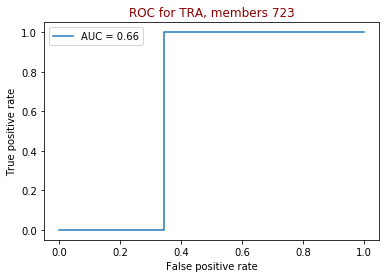

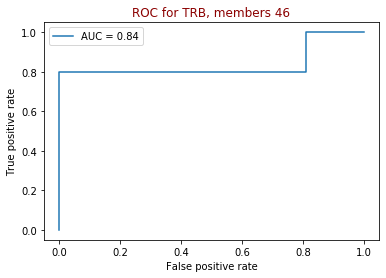

In [32]:
# plotting a ROC with AUC per cluster
for gene, data in clustered_data.groupby(['gene']):
    auc = roc_auc_score(data.target, data.epitope_weight)
    fpr, tpr, _ = roc_curve(data.target, data.epitope_weight)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='upper left')
    title = plt.title(f'ROC for {gene}, members {len(data)}')
    plt.setp(title, color='darkred')
    plt.show()